In [ ]:
# !pip install pmdarima
# !pip install vnstock

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from vnstock import stock_historical_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## **Data**

In [ ]:
acb = stock_historical_data("ACB", "2015-01-01", "2024-07-28", "1D")
mwg = stock_historical_data("MWG", "2015-01-01", "2024-07-28", "1D")
cmc = stock_historical_data("CMG", "2015-01-01", "2024-07-28", "1D")

In [ ]:
acb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385 entries, 0 to 2384
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    2385 non-null   object
 1   open    2385 non-null   int64 
 2   high    2385 non-null   int64 
 3   low     2385 non-null   int64 
 4   close   2385 non-null   int64 
 5   volume  2385 non-null   int64 
 6   ticker  2385 non-null   object
dtypes: int64(5), object(2)
memory usage: 130.6+ KB


In [ ]:
mwg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    2388 non-null   object
 1   open    2388 non-null   int64 
 2   high    2388 non-null   int64 
 3   low     2388 non-null   int64 
 4   close   2388 non-null   int64 
 5   volume  2388 non-null   int64 
 6   ticker  2388 non-null   object
dtypes: int64(5), object(2)
memory usage: 130.7+ KB


In [ ]:
cmc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    2389 non-null   object
 1   open    2389 non-null   int64 
 2   high    2389 non-null   int64 
 3   low     2389 non-null   int64 
 4   close   2389 non-null   int64 
 5   volume  2389 non-null   int64 
 6   ticker  2389 non-null   object
dtypes: int64(5), object(2)
memory usage: 130.8+ KB


In [ ]:
# Chuyển int --> float
acb['close'] = acb['close'].astype(float)
mwg['close'] = mwg['close'].astype(float)
cmc['close'] = cmc['close'].astype(float)

In [ ]:
def date(time_series):
    # Chuyển đổi cột Date sang định dạng datetime
    time_series['time'] = pd.to_datetime(time_series['time'], format='%Y-%m-%d')
    # Đặt cột time làm chỉ số (index)
    time_series.set_index('time', inplace=True)
    time_series = time_series[['close']]
    return time_series

In [ ]:
acb = date(acb)
mwg = date(mwg)
cmc = date(cmc)

In [ ]:
mwg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2388 entries, 2015-01-05 to 2024-07-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2388 non-null   float64
dtypes: float64(1)
memory usage: 37.3 KB


In [ ]:
print(acb.describe())

              close
count   2385.000000
mean   10884.270440
std     6321.066884
min     2790.000000
25%     5220.000000
50%     8370.000000
75%    17400.000000
max    25100.000000


In [ ]:
print(mwg.describe())

              close
count   2388.000000
mean   33952.690955
std    17792.755842
min     6700.000000
25%    21790.000000
50%    30155.000000
75%    44665.000000
max    78200.000000


In [ ]:
print(cmc.describe())

              close
count   2389.000000
mean   19025.561741
std    13641.720333
min     3180.000000
25%     6530.000000
50%    15570.000000
75%    31500.000000
max    70600.000000


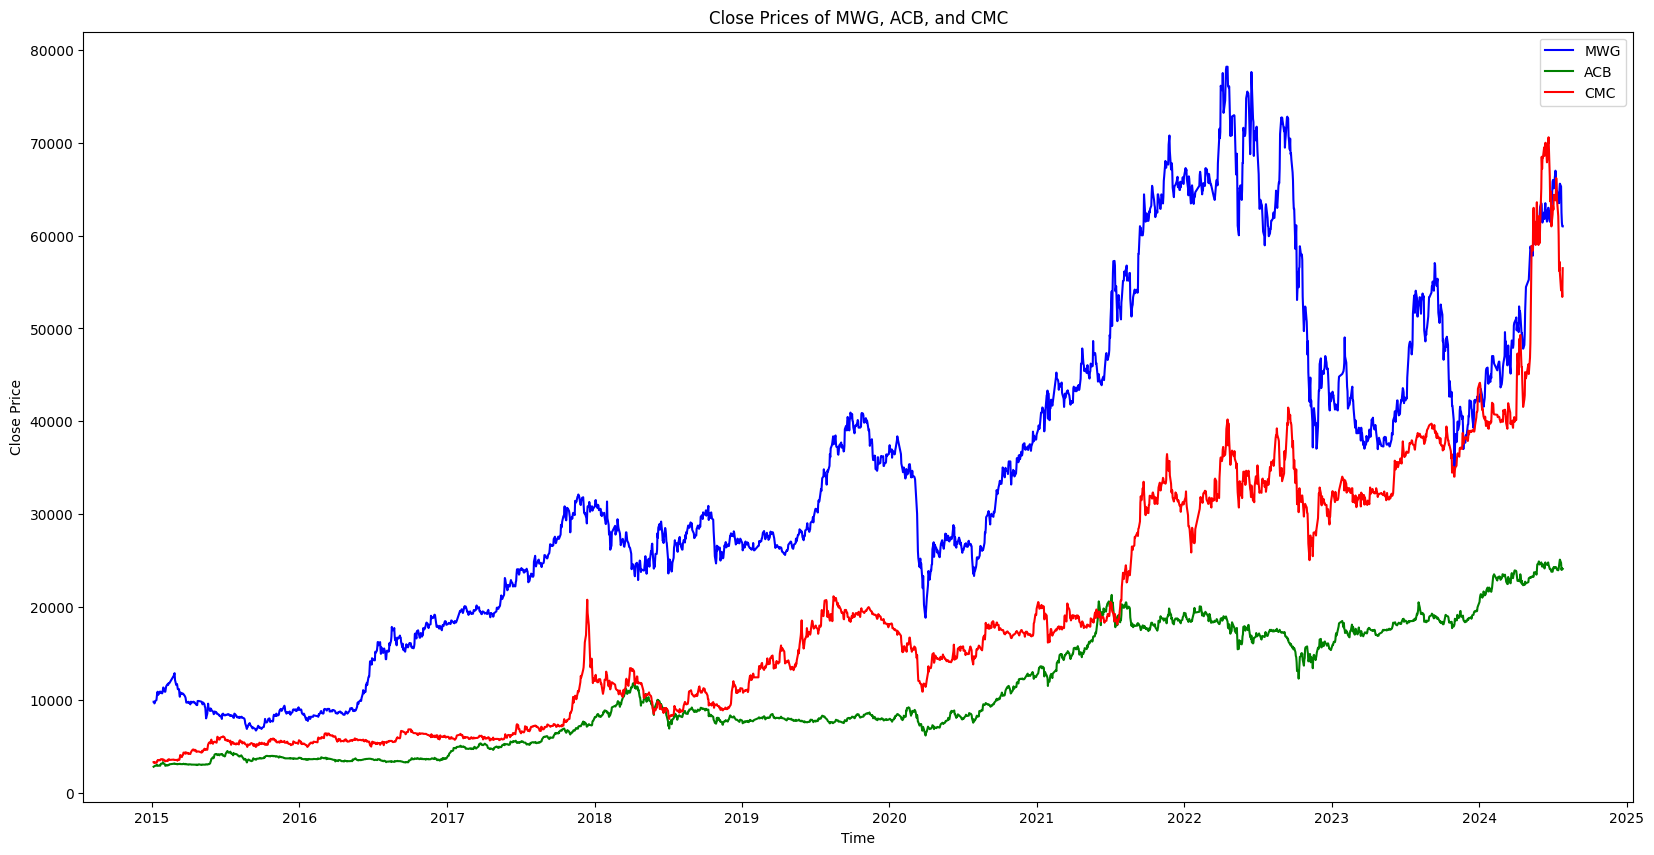

In [ ]:
# Tạo biểu đồ
plt.figure(figsize=(20, 10))

# Vẽ biểu đồ cho MWG
plt.plot(mwg.index, mwg['close'], label='MWG', color='blue')

# Vẽ biểu đồ cho ACB
plt.plot(acb.index, acb['close'], label='ACB', color='green')

# Vẽ biểu đồ cho CMC
plt.plot(cmc.index, cmc['close'], label='CMC', color='red')

# Thiết lập tiêu đề và nhãn trục
plt.title('Close Prices of MWG, ACB, and CMC')
plt.xlabel('Time')
plt.ylabel('Close Price')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

**Nhận xét:**
- Nhìn chung dữ liệu của cả 3 mã đều có xu hướng tăng theo thời gian
- Phương sai có vẻ cũng biến động khá mạnh

--> Chuỗi không dừng. Để chắc hơn về điều này, ta sẽ kiểm định với phương pháp ADF

## **Kiểm định tính dừng bằng ADF**

In [ ]:
def adf_test(series, name, alpha=0.05):
    result = adfuller(series)
    print(f'--- ADF Test for {name} ---')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    # Kết luận
    adf_statistic = result[0]
    critical_value = result[4]['5%']  # Giá trị tới hạn ở mức ý nghĩa 5%

    if adf_statistic < critical_value:
        print(f'Dữ liệu chuỗi thời gian với mã {name} đã dừng.')
    else:
        print(f'Dữ liệu chuỗi thời gian với mã {name} chưa dừng.')
    print(30*'---')

In [ ]:
# Kiểm định ADF cho MWG
adf_test(mwg['close'], 'MWG')

# Kiểm định ADF cho ACB
adf_test(acb['close'], 'ACB')

# Kiểm định ADF cho CMC
adf_test(cmc['close'], 'CMC')

--- ADF Test for MWG ---
ADF Statistic: -1.1089675482907064
p-value: 0.7114825333214362
Critical Values:
   1%: -3.433121558394153
   5%: -2.8627644283342697
   10%: -2.5674218159383577
Dữ liệu chuỗi thời gian với mã MWG chưa dừng.
------------------------------------------------------------------------------------------
--- ADF Test for ACB ---
ADF Statistic: 0.04559494548598067
p-value: 0.9621442094520608
Critical Values:
   1%: -3.433099417887619
   5%: -2.862754651535997
   10%: -2.5674166105654788
Dữ liệu chuỗi thời gian với mã ACB chưa dừng.
------------------------------------------------------------------------------------------
--- ADF Test for CMC ---
ADF Statistic: -0.13619731683925018
p-value: 0.9457116468492786
Critical Values:
   1%: -3.433121558394153
   5%: -2.8627644283342697
   10%: -2.5674218159383577
Dữ liệu chuỗi thời gian với mã CMC chưa dừng.
------------------------------------------------------------------------------------------


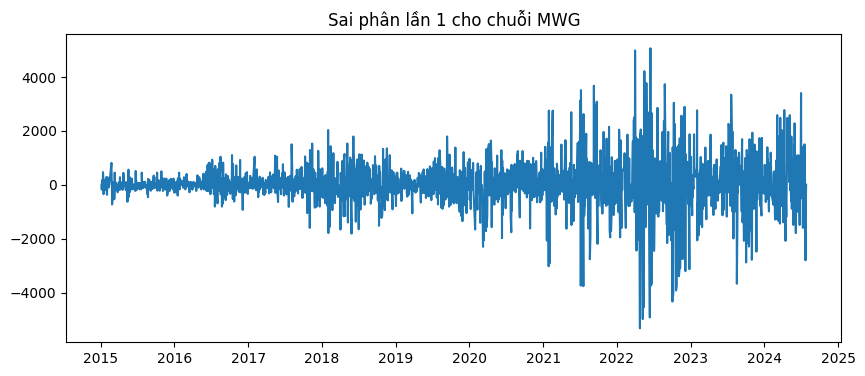

In [ ]:
# Tính sai phân lần thứ nhất để chuỗi dừng
mwg_diff1 = mwg['close'].diff().dropna()

# Vẽ chuỗi thời gian sau khi sai phân lần thứ nhất
plt.figure(figsize=(10, 4))
plt.plot(mwg_diff1)
plt.title('Sai phân lần 1 cho chuỗi MWG')
plt.show()

In [ ]:
# Kiểm định ADF cho diff MWG
adf_test(mwg_diff1, 'MWG_diff1')

--- ADF Test for MWG_diff1 ---
ADF Statistic: -9.505133196405225
p-value: 3.363140323906471e-16
Critical Values:
   1%: -3.433121558394153
   5%: -2.8627644283342697
   10%: -2.5674218159383577
Dữ liệu chuỗi thời gian với mã MWG_diff1 đã dừng.
------------------------------------------------------------------------------------------


In [ ]:
# tương tự với acb và cmc:
acb_diff1 = acb['close'].diff().dropna()
cmc_diff1 = cmc['close'].diff().dropna()

In [ ]:
adf_test(acb_diff1, 'MWG_diff1')
adf_test(cmc_diff1, 'MWG_diff1')

--- ADF Test for MWG_diff1 ---
ADF Statistic: -29.829145824344177
p-value: 0.0
Critical Values:
   1%: -3.433099417887619
   5%: -2.862754651535997
   10%: -2.5674166105654788
Dữ liệu chuỗi thời gian với mã MWG_diff1 đã dừng.
------------------------------------------------------------------------------------------
--- ADF Test for MWG_diff1 ---
ADF Statistic: -7.164037716666138
p-value: 2.9176843894519887e-10
Critical Values:
   1%: -3.4331239097346398
   5%: -2.8627654666342472
   10%: -2.5674223687517954
Dữ liệu chuỗi thời gian với mã MWG_diff1 đã dừng.
------------------------------------------------------------------------------------------


## **Đánh giá bộ tham số (p,d,q) trước khi xây dựng mô hình ARIMA**
- hiện tại cả 3 chuỗi đã dừng khi chỉ thực hiện duy nhất 1 lần sai phân, do đó hệ số d trong mô hình ARIMA là 1
- bước tiếp theo ta sẽ xác định hệ số p và q bằng cách kiểm tra mức độ tự tương quan ACF và tự tương quan riêng phần PACF

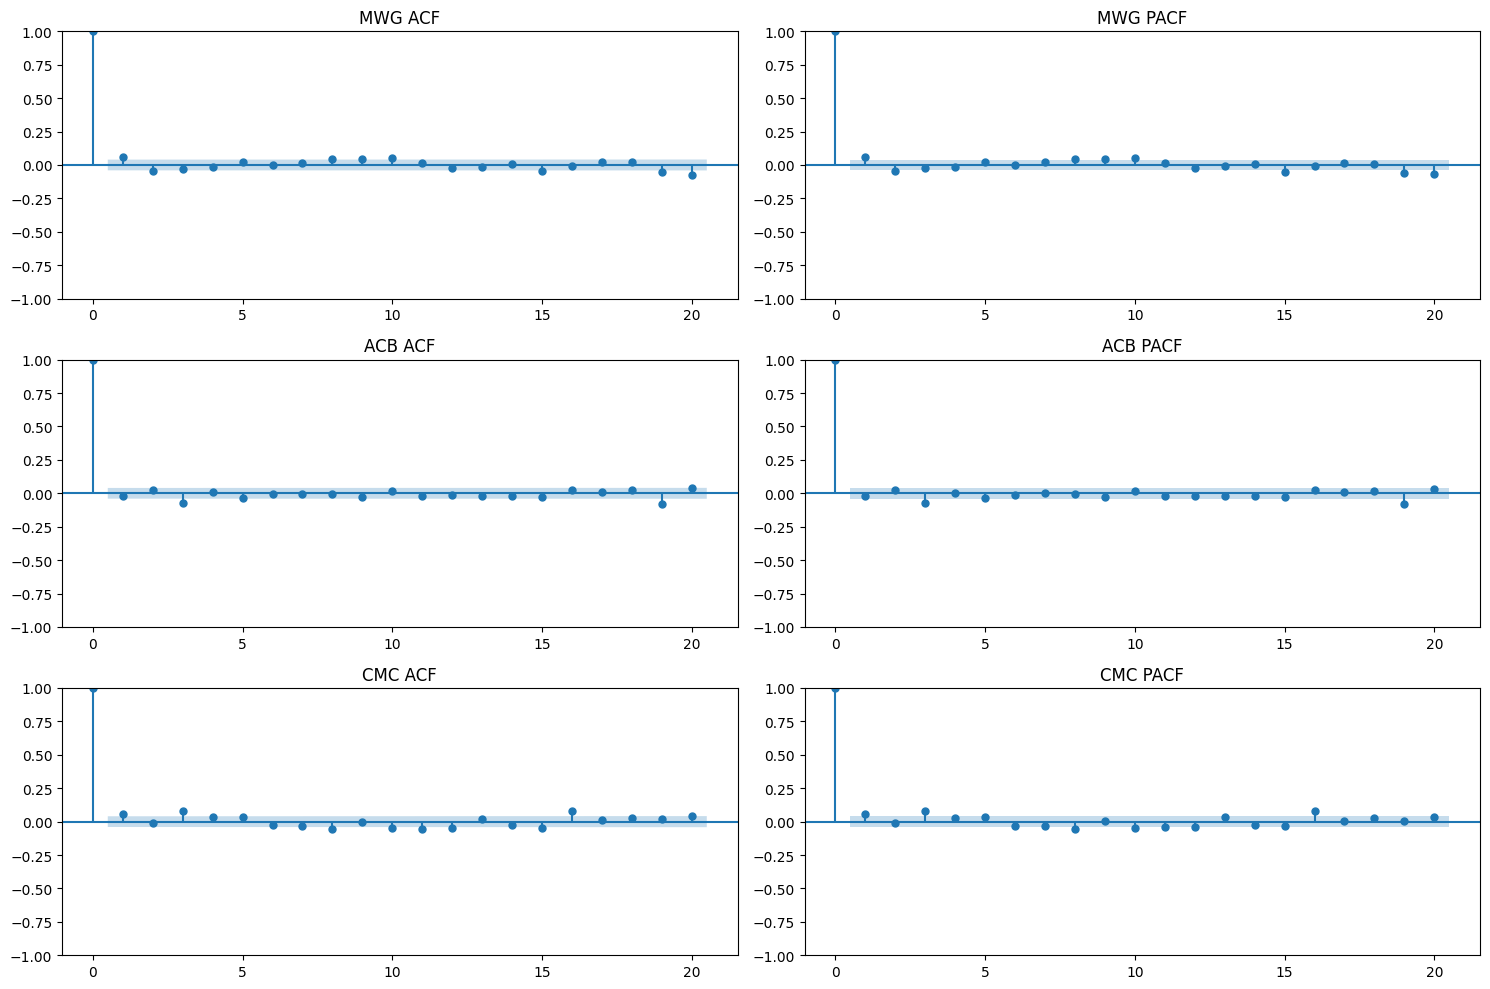

In [ ]:
# Vẽ biểu đồ ACF và PACF cho các chuỗi đã sai phân
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Biểu đồ cho MWG
plot_acf(mwg_diff1, lags=20, ax=axes[0, 0])
axes[0, 0].set_title('MWG ACF')
plot_pacf(mwg_diff1, lags=20, ax=axes[0, 1])
axes[0, 1].set_title('MWG PACF')

# Biểu đồ cho ACB
plot_acf(acb_diff1, lags=20, ax=axes[1, 0])
axes[1, 0].set_title('ACB ACF')
plot_pacf(acb_diff1, lags=20, ax=axes[1, 1])
axes[1, 1].set_title('ACB PACF')

# Biểu đồ cho CMC
plot_acf(cmc_diff1, lags=20, ax=axes[2, 0])
axes[2, 0].set_title('CMC ACF')
plot_pacf(cmc_diff1, lags=20, ax=axes[2, 1])
axes[2, 1].set_title('CMC PACF')

# Căn chỉnh và hiển thị biểu đồ
plt.tight_layout()
plt.show()

Nhìn vào biểu đồ thì ta có thể chọn ra các tham số cho mô hình như sau:
- MWG: (1,1,1)
- ACB: (2,1,2)
- CMC: (1,1,1)

Để chắc chắn hơn, ta sẽ sử dụng Auto_ARIMA để tìm ra bộ tham số tốt nhất

In [ ]:
# Tự động chọn các tham số ARIMA cho MWG
mwg_model = auto_arima(mwg, seasonal=False, trace=True)
print(mwg_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=38913.973, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38922.745, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38915.392, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38914.499, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38922.302, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=38913.347, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=38912.460, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=38912.711, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38914.271, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=38914.541, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38911.955, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38913.850, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=38912.543, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=38912.299, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0

In [ ]:
# Tự động chọn các tham số ARIMA cho ACB
acb_model = auto_arima(acb, seasonal=False, trace=True)
print(acb_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32522.532, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32532.964, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32534.118, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32534.162, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32534.820, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32524.176, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32524.176, Time=1.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=32524.288, Time=1.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=32524.404, Time=1.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32522.177, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32534.824, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=32534.525, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=32524.108, Time=0.25 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 7.170 seconds
         

In [ ]:
# Tự động chọn các tham số ARIMA cho CMC
cmc_model = auto_arima(cmc, seasonal=False, trace=True)
print(cmc_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=37287.459, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37300.916, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37294.898, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37294.661, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37302.251, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=37290.025, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=37289.911, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=37284.543, Time=0.78 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=37284.663, Time=0.43 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=37284.489, Time=1.32 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=37286.370, Time=0.87 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=37272.580, Time=2.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=37283.060, Time=0.89 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(4,1,3)(0,0,0)[0] i

**Lựa chọn tham số dựa trên ACF và PACF:** (p,d,q) của mwg, acb, cmc lần lượt là: (1,1,1), (2,1,2), (1,1,1)

**Lựa chọn tham số từ kết quả sau khi chạy auto-ARIMA:** (p,d,q) của mwg, acb, cmc lần lượt là: (0,1,2), (2,1,2), (5,1,2)

Vì auto-ARIMA đã chọn ra bộ số tốt nhất cho mô hình ARIMA bằng cách đánh giá trên chỉ số AIC thấp nhất nên ta sẽ sử dụng kết quả này để đưa vào mô hình của chúng ta.

## **Chia dữ liệu thành tập train và test**

In [ ]:

def train_test_split(df):
    train = df.loc['2015-01-01':'2023-12-31']
    test = df.loc['2024-01-01':'2024-07-31']
    return train, test

In [ ]:
# Chia tập huấn luyện và kiểm tra cho các chuỗi thời gian
mwg_train, mwg_test = train_test_split(mwg)
acb_train, acb_test = train_test_split(acb)
cmc_train, cmc_test = train_test_split(cmc)

In [ ]:
mwg_train

,close
time,
2015-01-05,9790.0
2015-01-06,9790.0
2015-01-07,9610.0
2015-01-08,9700.0
2015-01-09,9870.0
...,...
2023-12-25,42310.0
2023-12-26,42360.0
2023-12-27,42510.0


In [ ]:
mwg_test

,close
time,
2024-01-02,42120.0
2024-01-03,42860.0
2024-01-04,42860.0
2024-01-05,43500.0
2024-01-08,42860.0
...,...
2024-07-22,65300.0
2024-07-23,62500.0
2024-07-24,61400.0


## **ARIMA thông thường**

In [ ]:
# Hàm lưu mô hình
def save_model_to_drive(model, model_name):
    # Đường dẫn tới thư mục trên Google Drive
    save_path = f'/content/drive/Shareddrives/PRO PLAYER/2. Kỳ hè năm 3/2. A Phúc/Final/Code/Save Model/{model_name}.pkl'
    # Lưu mô hình bằng joblib
    joblib.dump(model, save_path)
    print(f'Mô hình đã được lưu tại: {save_path}')

In [ ]:
# Huấn luyện và dự báo sử dụng mô hình ARIMA tự động
def train_auto_arima(train, test):
    # Sử dụng auto_arima để tìm các tham số tối ưu
    auto_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    print(auto_model.summary())  # In thông tin mô hình tìm được

    # Huấn luyện mô hình ARIMA với các tham số được auto_arima chọn
    model = ARIMA(train, order=auto_model.order)
    model_fit = model.fit()

    # Dự báo trên tập kiểm tra
    forecast = model_fit.forecast(steps=len(test))
    # forecast = model_fit.fittedvalues  # Dự đoán trên dữ liệu đã lắp đặt

    return forecast, model_fit

In [ ]:
# Thực hiện trên dữ liệu 'close' cho các cổ phiếu
mwg_forecast, mwg_model = train_auto_arima(mwg_train['close'], mwg_test['close'])
acb_forecast, acb_model = train_auto_arima(acb_train['close'], acb_test['close'])
cmc_forecast, cmc_model = train_auto_arima(cmc_train['close'], cmc_test['close'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=36564.420, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36571.453, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36565.366, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36564.556, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36570.148, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=36563.453, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=36562.486, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=36562.719, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=36564.463, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=36564.713, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=36561.156, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=36563.158, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=36562.021, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=36561.432, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=30507.602, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30513.107, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30514.335, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30514.376, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30513.940, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=30509.708, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30509.707, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=30508.046, Time=1.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=30508.186, Time=1.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30507.760, Time=0.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=30511.788, Time=0.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=30512.015, Time=0.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=30509.706, Time=0.44 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 10.99

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=34134.230, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34141.206, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34140.814, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34140.443, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34142.325, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=34132.777, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=34132.435, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=34131.011, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=34130.793, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=34127.038, Time=0.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=34125.569, Time=2.06 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=34130.756, Time=0.55 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=34124.258, Time=1.90 sec
 ARIMA(4,1,4)(0,0,0)[0] i

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [ ]:
# Vẽ biểu đồ kết quả dự báo
def plot_forecast(train, test, forecast, title):
    plt.figure(figsize=(10, 6))
    # plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast', color='red')
    plt.title(title)
    plt.legend()
    plt.show()

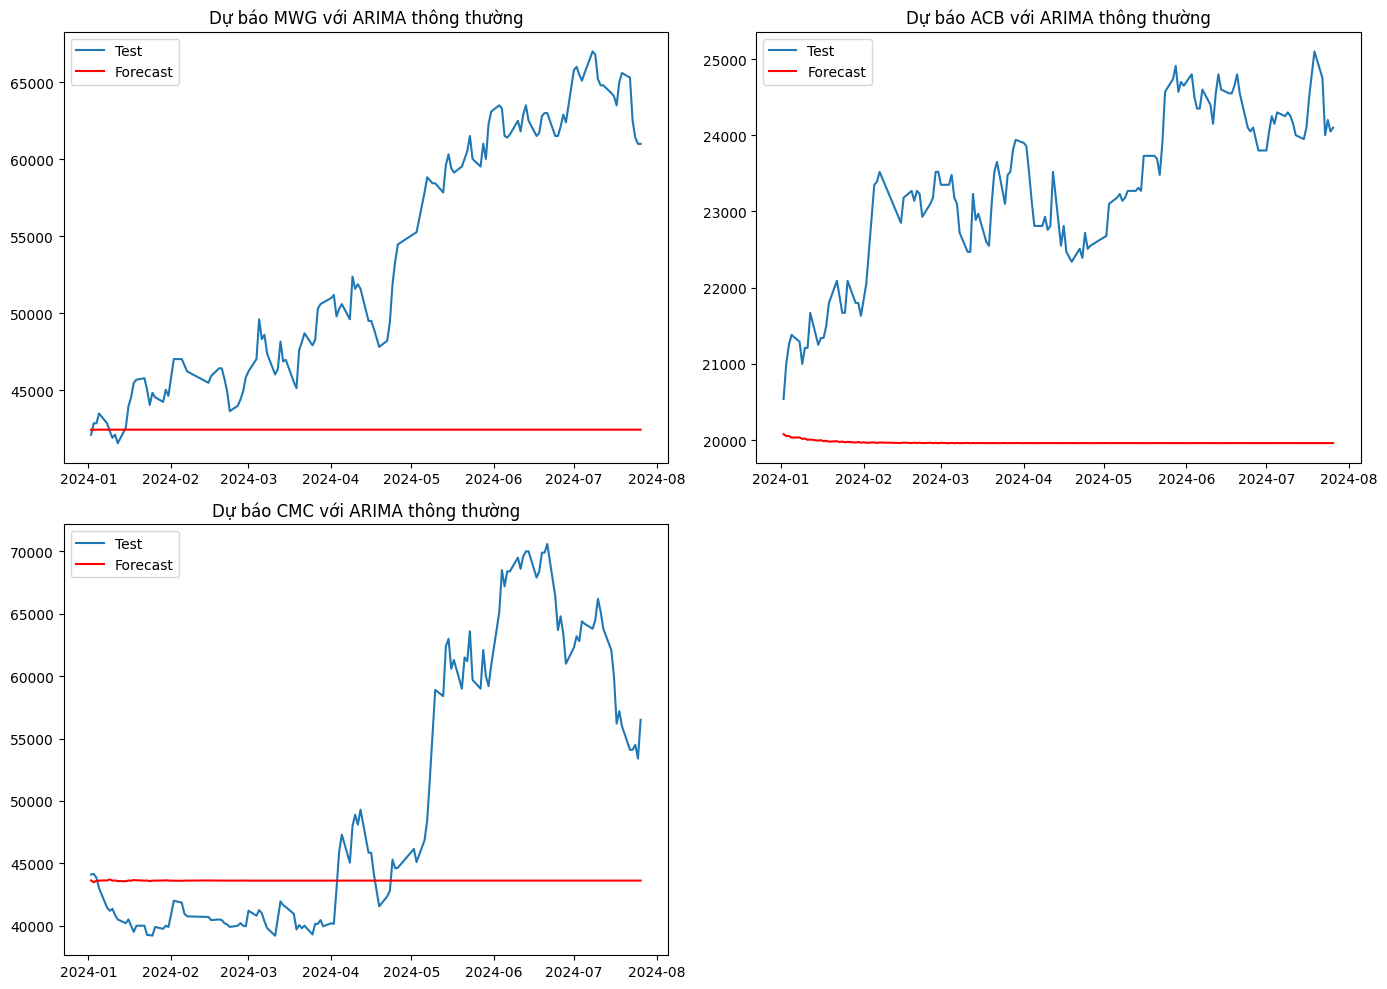

In [ ]:
def plot_forecasts(train_data, test_data, forecasts, titles):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Tạo lưới 2x2 cho biểu đồ
    axes = axes.flatten()  # Làm phẳng mảng các trục để dễ truy cập

    # Vòng lặp qua từng cặp dữ liệu và tiến hành vẽ
    for i, (train, test, forecast, title) in enumerate(zip(train_data, test_data, forecasts, titles)):
        # axes[i].plot(train.index, train, label='Train')
        axes[i].plot(test.index, test, label='Test')
        axes[i].plot(test.index, forecast, label='Forecast', color='red')
        axes[i].set_title(title)
        axes[i].legend()

    # Xóa trục không sử dụng
    axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

# Dữ liệu huấn luyện, kiểm tra, dự báo và tiêu đề cho mỗi biểu đồ
train_data = [mwg_train, acb_train, cmc_train]
test_data = [mwg_test, acb_test, cmc_test]
forecasts = [mwg_forecast, acb_forecast, cmc_forecast]
titles = ['Dự báo MWG với ARIMA thông thường', 'Dự báo ACB với ARIMA thông thường', 'Dự báo CMC với ARIMA thông thường']

# Gọi hàm vẽ biểu đồ
plot_forecasts(train_data, test_data, forecasts, titles)

## **ARIMA kết hợp kĩ thuật sliding window (rolling window)**

In [ ]:
def rolling_forecast_auto(train, test, window_size):
    # Khởi tạo mô hình ARIMA tự động và lấy các tham số tối ưu
    auto_model = auto_arima(train, seasonal=False, trace=True)
    p, d, q = auto_model.order
    # print(auto_model.summary())

    history = train[-window_size:].tolist()
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        history = history[1:]

    return predictions

In [ ]:
# Áp dụng cho tập dữ liệu MWG, ACB, CMC
mwg_sliding_forecast = rolling_forecast_auto(mwg_train['close'], mwg_test['close'], window_size=5)
acb_sliding_forecast = rolling_forecast_auto(acb_train['close'], acb_test['close'], window_size=5)
cmc_sliding_forecast = rolling_forecast_auto(cmc_train['close'], cmc_test['close'], window_size=5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=36564.420, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36571.453, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36565.366, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36564.556, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36570.148, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=36563.453, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=36562.486, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=36562.719, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=36564.463, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=36564.713, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=36561.156, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=36563.158, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=36562.021, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=36561.432, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-37-b710f7ef899f>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=30507.602, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30513.107, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30514.335, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30514.376, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30513.940, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=30509.708, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30509.707, Time=1.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=30508.046, Time=1.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=30508.186, Time=1.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30507.760, Time=0.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=30511.788, Time=0.98 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=30512.015, Time=0.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=30509.706, Time=0.50 sec

Best model:  ARIMA(2,1,2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
<ipython-input-37-b710f7ef899f>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=34134.230, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34141.206, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34140.814, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34140.443, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34142.325, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=34132.777, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=34132.435, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=34131.011, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=34130.793, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=34127.038, Time=0.85 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=34125.569, Time=2.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=34130.756, Time=0.64 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=34124.258, Time=2.14 sec
 ARIMA(4,1,4)(0,0,0)[0] i

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
<ipython-input-37-b710f7ef899f>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

In [ ]:
def plot_forecast_grid(train_data, test_data, forecasts, titles, company_names):
    # Thiết lập grid 2x2 cho biểu đồ
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))
    fig.suptitle('Dự báo ARIMA kết hợp kĩ thuật Sliding Window cho các công ty')

    # Vẽ các biểu đồ cho từng công ty
    for i, company_name in enumerate(company_names):
        row, col = divmod(i, 2)
        # axs[row, col].plot(train_data[i].index, train_data[i]['close'], label='Actual')
        axs[row, col].plot(test_data[i].index, test_data[i]['close'], label='Test')
        axs[row, col].plot(test_data[i].index, forecasts[i], label='Forecast')
        axs[row, col].set_title(titles[i])
        axs[row, col].legend()

    # Ẩn biểu đồ thứ tư nếu có
    if len(company_names) < 4:
        axs[1, 1].axis('off')

    # Hiển thị biểu đồ
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

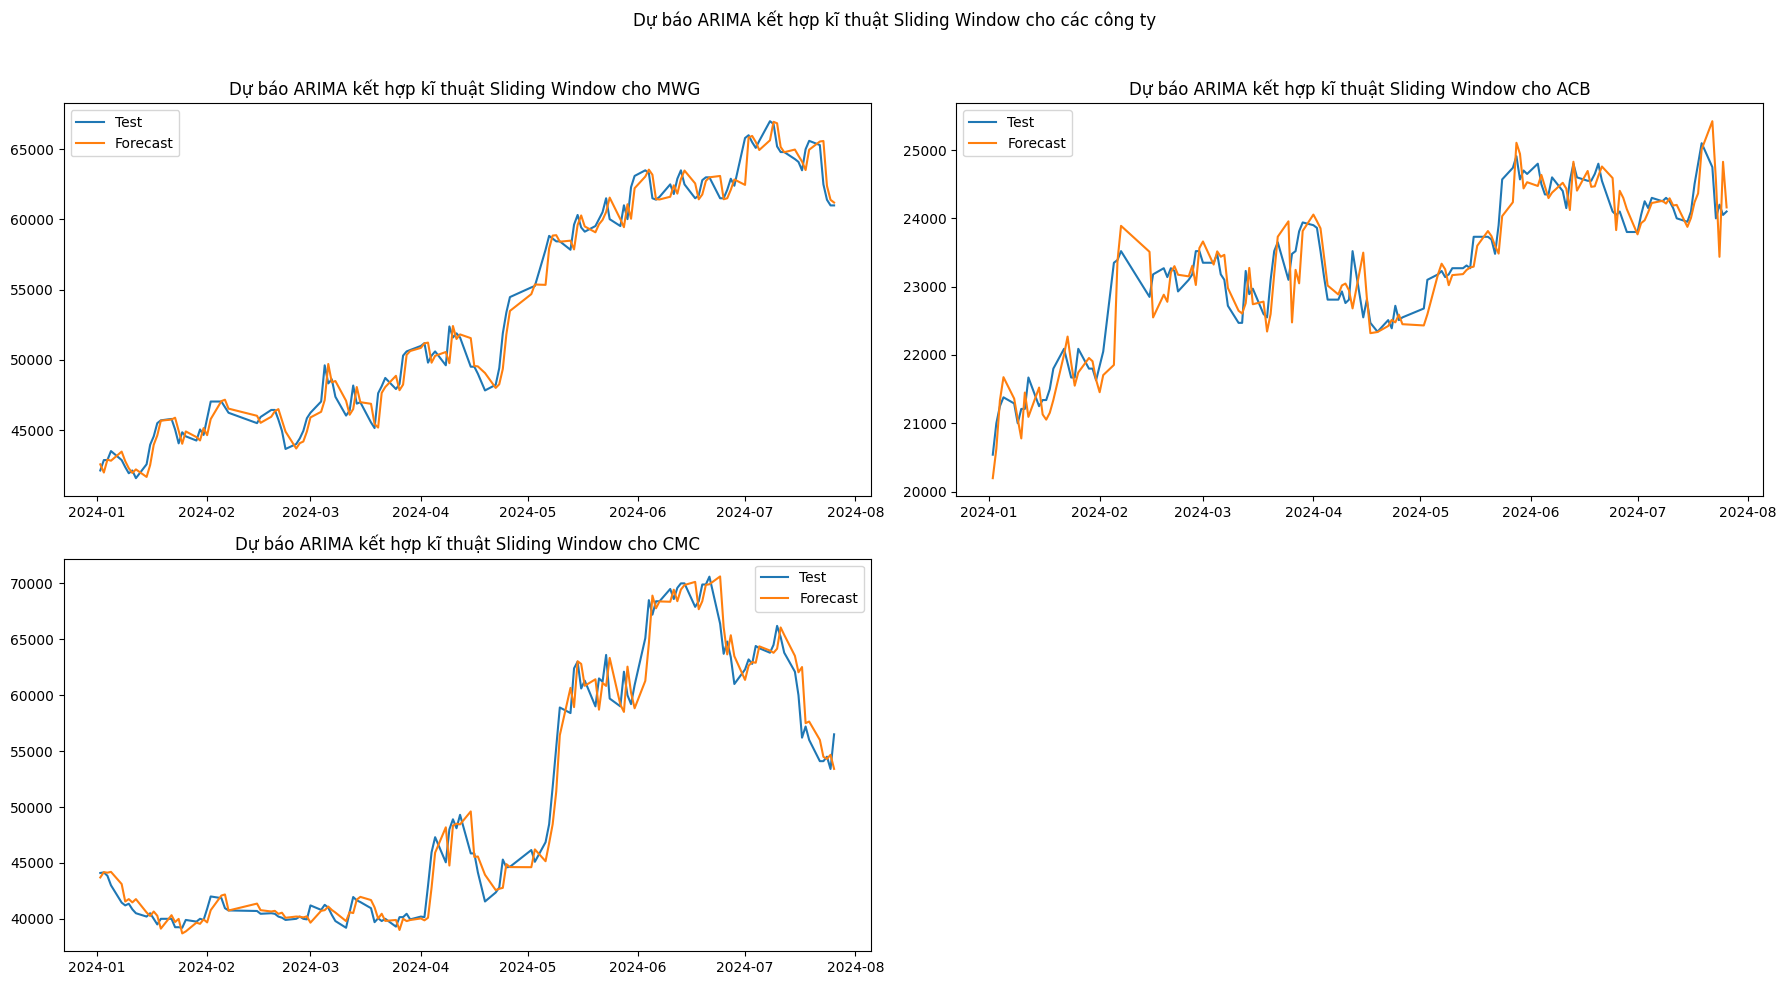

In [ ]:
company_names = ['MWG', 'ACB', 'CMC']
titles = ['Dự báo ARIMA kết hợp kĩ thuật Sliding Window cho MWG ', 'Dự báo ARIMA kết hợp kĩ thuật Sliding Window cho ACB', 'Dự báo ARIMA kết hợp kĩ thuật Sliding Window cho CMC']
plot_forecast_grid(
    [mwg, acb, cmc],
    [mwg_test, acb_test, cmc_test],    # List of testing data
    [mwg_sliding_forecast, acb_sliding_forecast, cmc_sliding_forecast],  # List of forecasts
    titles,
    company_names
)

In [ ]:
def print_evaluation_metrics(test, predictions):
    # Kiểm tra và chuyển đổi kiểu dữ liệu nếu cần
    test = np.array(test).astype(float)
    predictions = np.array(predictions).astype(float)

    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, predictions)
    epsilon = 1e-10  # Số nhỏ để tránh chia cho zero
    mape = np.mean(np.abs((test - predictions) / (test + epsilon))) * 100
    r2 = r2_score(test, predictions)

    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Absolute Percentage Error: {mape}%")
    print(f"R^2 Score: {r2}")

In [ ]:
# Đánh giá mô hình mwg với arima thông thường
print("Đánh giá độ chính xác của mô hình ARIMA MWG thông thường:")
print_evaluation_metrics(mwg_test['close'], mwg_forecast)
print(30*'-----')
print("Đánh giá độ chính xác của mô hình ARIMA MWG kết hợp kĩ thuật Sliding Window:")
# Đánh giá mô hình mwg với kĩ thuật sliding window
print_evaluation_metrics(mwg_test['close'], mwg_sliding_forecast)

Đánh giá độ chính xác của mô hình ARIMA MWG thông thường:
Mean Squared Error: 188429769.25067362
Root Mean Squared Error: 13726.97232643359
Mean Absolute Error: 11188.040622707389
Mean Absolute Percentage Error: 19.108782037717273%
R^2 Score: -1.9469337206973543
------------------------------------------------------------------------------------------------------------------------------------------------------
Đánh giá độ chính xác của mô hình ARIMA MWG kết hợp kĩ thuật Sliding Window:
Mean Squared Error: 1040860.2448432241
Root Mean Squared Error: 1020.2255852718182
Mean Absolute Error: 778.4810082095777
Mean Absolute Percentage Error: 1.4667888545715075%
R^2 Score: 0.9837215416318786


In [ ]:
# Đánh giá mô hình acb với arima thông thường
print("Đánh giá độ chính xác của mô hình ARIMA ACB thông thường:")
print_evaluation_metrics(acb_test['close'], acb_forecast)
print(30*'-----')
print("Đánh giá độ chính xác của mô hình ARIMA ACB kết hợp kĩ thuật Sliding Window:")
# Đánh giá mô hình acb với kĩ thuật sliding window
print_evaluation_metrics(acb_test['close'], acb_sliding_forecast)


Đánh giá độ chính xác của mô hình ARIMA ACB thông thường:
Mean Squared Error: 12046450.62142138
Root Mean Squared Error: 3470.799709205557
Mean Absolute Error: 3306.9095731762804
Mean Absolute Percentage Error: 14.029351815670775%
R^2 Score: -10.11562396080377
------------------------------------------------------------------------------------------------------------------------------------------------------
Đánh giá độ chính xác của mô hình ARIMA ACB kết hợp kĩ thuật Sliding Window:
Mean Squared Error: 121403.44900192996
Root Mean Squared Error: 348.4299771861341
Mean Absolute Error: 258.960974841518
Mean Absolute Percentage Error: 1.1147468310921462%
R^2 Score: 0.8879773695124444


In [ ]:
# Đánh giá mô hình cmc với arima thông thường
print("Đánh giá độ chính xác của mô hình ARIMA CMC thông thường:")
print_evaluation_metrics(cmc_test['close'], cmc_forecast)
print(30*'-----')
print("Đánh giá độ chính xác của mô hình ARIMA CMC kết hợp kĩ thuật Sliding Window:")
# Đánh giá mô hình cmc với kĩ thuật sliding window
print_evaluation_metrics(cmc_test['close'], cmc_sliding_forecast)

Đánh giá độ chính xác của mô hình ARIMA CMC thông thường:
Mean Squared Error: 165753828.13394523
Root Mean Squared Error: 12874.541861128311
Mean Absolute Error: 9595.03440115812
Mean Absolute Percentage Error: 16.521376365058078%
R^2 Score: -0.4003911314864126
------------------------------------------------------------------------------------------------------------------------------------------------------
Đánh giá độ chính xác của mô hình ARIMA CMC kết hợp kĩ thuật Sliding Window:
Mean Squared Error: 2694080.22622445
Root Mean Squared Error: 1641.365354278093
Mean Absolute Error: 1158.2963998251948
Mean Absolute Percentage Error: 2.2086886946683877%
R^2 Score: 0.9772387395284237


## **ARIMA kết hợp kĩ thuật expanding window**

In [ ]:
def expanding_window_forecast(train, test):
    # Tìm tham số tối ưu bằng auto_arima
    auto_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    p, d, q = auto_model.order
    # print(auto_model.summary())  # In thông tin mô hình tìm được

    history = train.tolist()  # Bắt đầu với toàn bộ tập huấn luyện
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t])  # Cập nhật lịch sử bằng cách thêm quan sát thực tế

    return predictions

In [ ]:
# Áp dụng cho tập dữ liệu MWG, ACB, CMC
mwg_expanding_forecast = expanding_window_forecast(mwg_train['close'], mwg_test['close'])
acb_expanding_forecast = expanding_window_forecast(acb_train['close'], acb_test['close'])
cmc_expanding_forecast = expanding_window_forecast(cmc_train['close'], cmc_test['close'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=36564.420, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36571.453, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36565.366, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36564.556, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36570.148, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=36563.453, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=36562.486, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=36562.719, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=36564.463, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=36564.713, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=36561.156, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=36563.158, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=36562.021, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=36561.432, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [ ]:
def plot_forecast_grid(data, test_data, forecasts, titles, company_names):
    # Thiết lập grid 2x2 cho biểu đồ
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))
    fig.suptitle('Dự báo ARIMA kết hợp kĩ thuật Expanding Window cho các công ty')

    # Vẽ các biểu đồ cho từng công ty
    for i, company_name in enumerate(company_names):
        row, col = divmod(i, 2)
        # axs[row, col].plot(train_data[i].index[-100:], train_data[i]['close'][-100:], label='Train', color='#0033FF')
        # axs[row, col].plot(data[i].index, data[i]['close'], label='Actual', color='blue')
        axs[row, col].plot(test_data[i].index, test_data[i]['close'], label='Test')
        axs[row, col].plot(test_data[i].index, forecasts[i], label='Forecast')
        axs[row, col].set_title(titles[i])
        axs[row, col].legend()

    # Ẩn biểu đồ thứ tư nếu có
    if len(company_names) < 4:
        axs[1, 1].axis('off')

    # Hiển thị biểu đồ
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

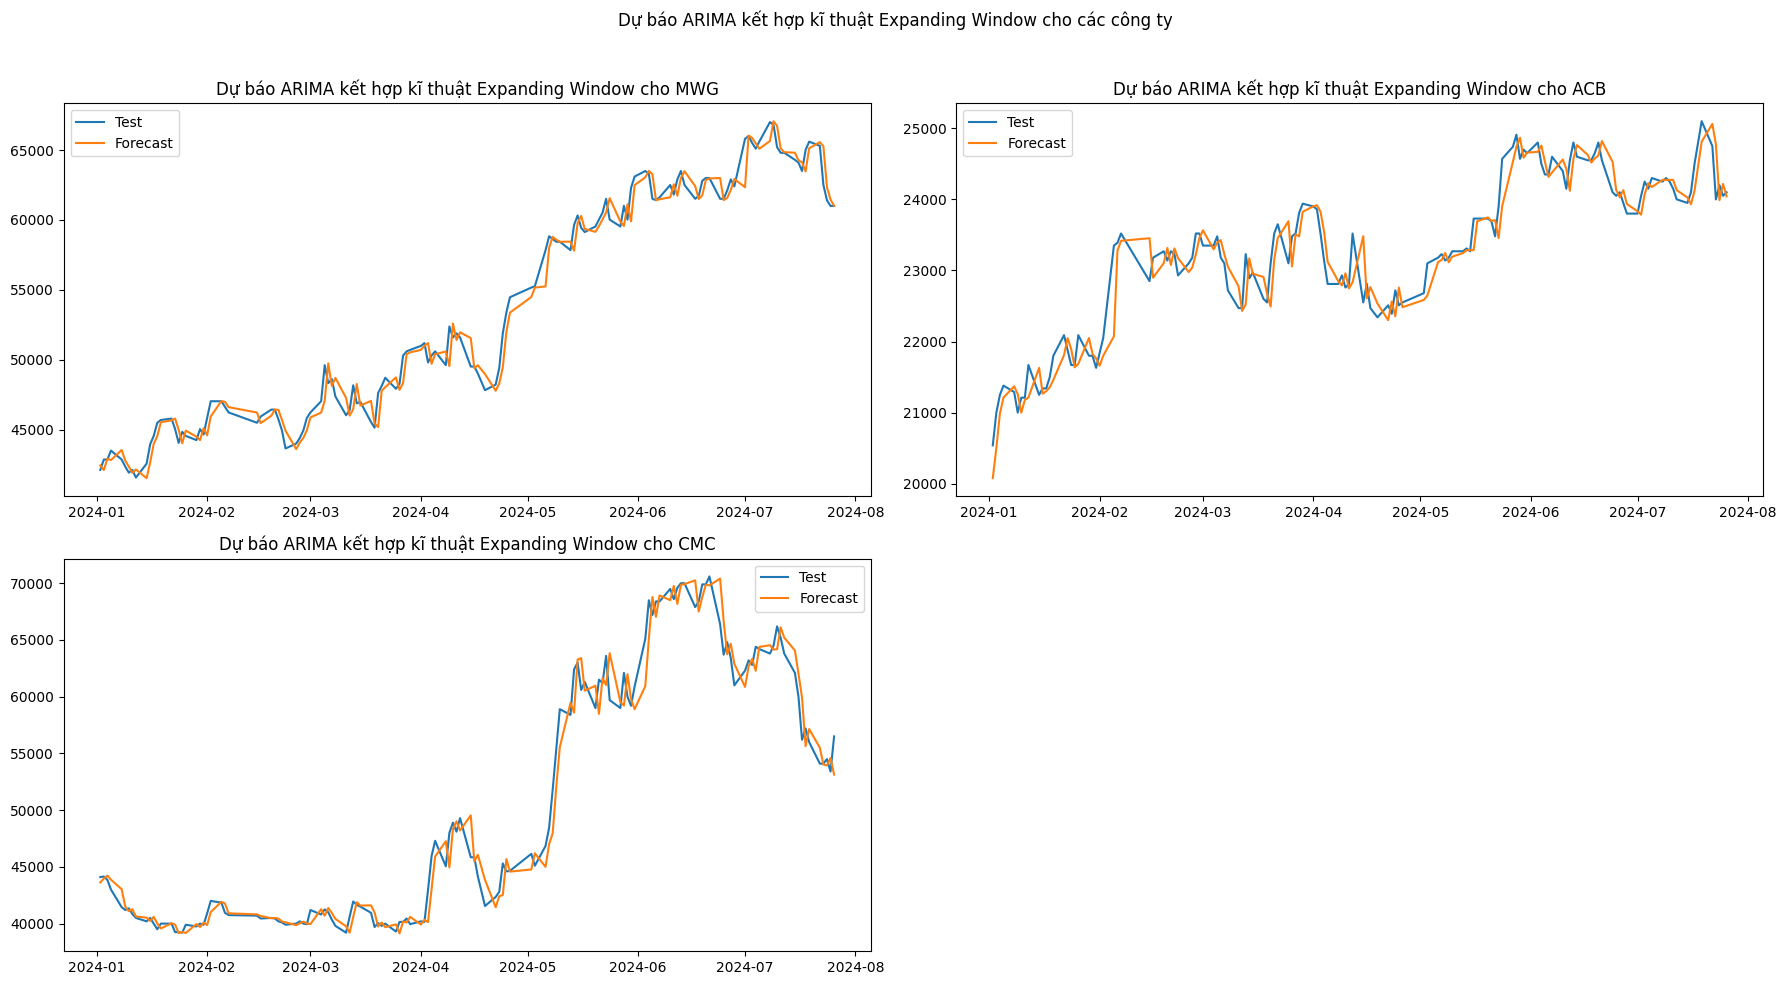

In [ ]:
company_names = ['MWG', 'ACB', 'CMC']
titles = ['Dự báo ARIMA kết hợp kĩ thuật Expanding Window cho MWG', 'Dự báo ARIMA kết hợp kĩ thuật Expanding Window cho ACB', 'Dự báo ARIMA kết hợp kĩ thuật Expanding Window cho CMC']
plot_forecast_grid(
    [mwg, acb, cmc],
    [mwg_test, acb_test, cmc_test],
    [mwg_expanding_forecast, acb_expanding_forecast, cmc_expanding_forecast],  # List of forecasts
    titles,
    company_names
)

## **Đánh giá model**

In [ ]:
# Đánh giá mô hình mwg với arima thông thường
print("Đánh giá độ chính xác của mô hình ARIMA MWG thông thường:")
print_evaluation_metrics(mwg_test['close'], mwg_forecast)
print(30*'-----')
print("Đánh giá độ chính xác của mô hình ARIMA MWG kết hợp kĩ thuật Sliding Window:")
# Đánh giá mô hình mwg với kĩ thuật sliding window
print_evaluation_metrics(mwg_test['close'], mwg_sliding_forecast)
print(30*'-----')
print("Đánh giá độ chính xác của mô hình ARIMA MWG kết hợp kĩ thuật Expanding Window:")
# Đánh giá mô hình mwg với kĩ thuật sliding window
print_evaluation_metrics(mwg_test['close'], mwg_expanding_forecast)


Đánh giá độ chính xác của mô hình ARIMA MWG thông thường:
Mean Squared Error: 188429769.25067362
Root Mean Squared Error: 13726.97232643359
Mean Absolute Error: 11188.040622707389
Mean Absolute Percentage Error: 19.108782037717273%
R^2 Score: -1.9469337206973543
------------------------------------------------------------------------------------------------------------------------------------------------------
Đánh giá độ chính xác của mô hình ARIMA MWG kết hợp kĩ thuật Sliding Window:
Mean Squared Error: 1040860.2448432241
Root Mean Squared Error: 1020.2255852718182
Mean Absolute Error: 778.4810082095777
Mean Absolute Percentage Error: 1.4667888545715075%
R^2 Score: 0.9837215416318786
------------------------------------------------------------------------------------------------------------------------------------------------------
Đánh giá độ chính xác của mô hình ARIMA MWG kết hợp kĩ thuật Expanding Window:
Mean Squared Error: 1042895.4523986159
Root Mean Squared Error: 1021.222528

In [ ]:
# Đánh giá mô hình acb với arima thông thường
print("Đánh giá độ chính xác của mô hình ARIMA ACB thông thường:")
print_evaluation_metrics(acb_test['close'], acb_forecast)
print(30*'-----')
print("Đánh giá độ chính xác của mô hình ARIMA ACB kết hợp kĩ thuật Sliding Window:")
# Đánh giá mô hình acb với kĩ thuật sliding window
print_evaluation_metrics(acb_test['close'], acb_sliding_forecast)
print(30*'-----')
print("Đánh giá độ chính xác của mô hình ARIMA ACB kết hợp kĩ thuật Expanding Window:")
# Đánh giá mô hình acb với kĩ thuật sliding window
print_evaluation_metrics(acb_test['close'], acb_expanding_forecast)

Đánh giá độ chính xác của mô hình ARIMA ACB thông thường:
Mean Squared Error: 12046450.62142138
Root Mean Squared Error: 3470.799709205557
Mean Absolute Error: 3306.9095731762804
Mean Absolute Percentage Error: 14.029351815670775%
R^2 Score: -10.11562396080377
------------------------------------------------------------------------------------------------------------------------------------------------------
Đánh giá độ chính xác của mô hình ARIMA ACB kết hợp kĩ thuật Sliding Window:
Mean Squared Error: 121403.44900192996
Root Mean Squared Error: 348.4299771861341
Mean Absolute Error: 258.960974841518
Mean Absolute Percentage Error: 1.1147468310921462%
R^2 Score: 0.8879773695124444
------------------------------------------------------------------------------------------------------------------------------------------------------
Đánh giá độ chính xác của mô hình ARIMA ACB kết hợp kĩ thuật Expanding Window:
Mean Squared Error: 85794.03207509902
Root Mean Squared Error: 292.906183060547

In [ ]:
# Đánh giá mô hình cmc với arima thông thường
print("Đánh giá độ chính xác của mô hình ARIMA CMC thông thường:")
print_evaluation_metrics(cmc_test['close'], cmc_forecast)
print(30*'-----')
print("Đánh giá độ chính xác của mô hình ARIMA CMC kết hợp kĩ thuật Sliding Window:")
# Đánh giá mô hình cmc với kĩ thuật sliding window
print_evaluation_metrics(cmc_test['close'], cmc_sliding_forecast)
print(30*'-----')
print("Đánh giá độ chính xác của mô hình ARIMA CMC kết hợp kĩ thuật Expanding Window:")
# Đánh giá mô hình cmc với kĩ thuật sliding window
print_evaluation_metrics(cmc_test['close'], cmc_expanding_forecast)

Đánh giá độ chính xác của mô hình ARIMA CMC thông thường:
Mean Squared Error: 165753828.13394523
Root Mean Squared Error: 12874.541861128311
Mean Absolute Error: 9595.03440115812
Mean Absolute Percentage Error: 16.521376365058078%
R^2 Score: -0.4003911314864126
------------------------------------------------------------------------------------------------------------------------------------------------------
Đánh giá độ chính xác của mô hình ARIMA CMC kết hợp kĩ thuật Sliding Window:
Mean Squared Error: 2694080.22622445
Root Mean Squared Error: 1641.365354278093
Mean Absolute Error: 1158.2963998251948
Mean Absolute Percentage Error: 2.2086886946683877%
R^2 Score: 0.9772387395284237
------------------------------------------------------------------------------------------------------------------------------------------------------
Đánh giá độ chính xác của mô hình ARIMA CMC kết hợp kĩ thuật Expanding Window:
Mean Squared Error: 2463070.396227853
Root Mean Squared Error: 1569.4172154745